Oksana Dereza

## Triphones clustering

In [1]:
import os
from collections import defaultdict
import numpy as np

In [2]:
filenames = os.listdir('./DATA/np_data')
uids = list(set([fname.split('.')[0] for fname in filenames]))

In [4]:
# cutting off position suffixes (_B, _I, _E, _S) from phonemes & creating mapping

def map_phonemes(path):
    mapping = {}
    with open(path, 'r', encoding='utf-8') as f:
        for line in f:
            phoneme, index = line.strip().split('')
            index = int(index)
            if '_' in phoneme:
                mapping[index] = phoneme.split('_')[0]
            else:
                mapping[index] = phoneme
    return mapping

mapping = map_phonemes('./DATA/data/lang/phones.txt')

In [5]:
mapping[88]

'ER1'

In [37]:
# converting monophones into triphones

data = defaultdict(list)

for uid in uids:
    feats = np.load('./DATA/np_data/{}.feats.npy'.format(uid))
    alis = np.load('./DATA/np_data/{}.targs.npy'.format(uid))
    phonemes = ['START']  # start symbol
    features = [[]]
    for phoneme, feature in zip(alis, feats):
        phoneme = mapping[phoneme]
        if phoneme == phonemes[-1]:
            features[-1].append(feature)
        else:
            features.append([])
            features[-1].append(feature)
            phonemes.append(phoneme)
    phonemes = phonemes[1:]
    features = features[1:]
    for i in range(1, len(phonemes) - 1):
        triphone = tuple(phonemes[i-1:i+2])
        data[triphone] += features[i]

In [38]:
print('Number of triphones: %s' % (len(data.keys())))
print('Sample: %s' % (list(data.keys())[:10]))

Number of triphones: 17307
Sample: [('IH0', 'DH', 'R'), ('M', 'EY1', 'P'), ('AW1', 'S', 'IH1'), ('P', 'AE1', 'N'), ('EY1', 'G', 'EU0'), ('W', 'IH0', 'Z'), ('L', 'OW1', 'B'), ('N', 'D', 'CH'), ('UW0', 'F', 'R'), ('T', 'IY0', 'R')]


In [39]:
print(data[('IH0', 'DH', 'R')])

[array([-3.35879278, -0.24518494, -0.32179695, -0.06910479,  1.34252429,
       -0.07772409,  0.06063945, -1.5012356 , -2.1997838 ,  0.79221982,
        0.793495  , -2.16503739, -0.0431839 ,  1.02503085,  1.86534142,
        0.73354459, -1.48368454, -0.57550091, -0.07393479,  3.29659271,
       -0.38262987,  0.69824642,  1.12460971,  1.32969475, -1.11506295,
        1.60301566, -0.22050501,  0.29984286,  1.77405965, -0.79953063,
        1.70161712,  0.54223025,  1.4444561 ,  0.15663631,  1.54148042,
       -1.030586  , -2.61552405,  0.11099725, -1.38932371, -0.85504031], dtype=float32), array([-3.59817648, -0.3649058 , -0.13059857, -1.83670104,  1.94887221,
       -0.29427305, -0.31764084, -1.28913152, -0.48805884,  0.32732424,
        1.54780662, -1.90186024, -0.32338622,  1.11601841,  2.08085608,
        0.14630698, -0.33712101, -0.1812534 , -0.97657591,  3.42336082,
       -1.80113554,  1.7958039 ,  1.45860541,  1.24358404, -1.89567232,
       -0.00872638,  0.2345255 ,  0.92061841, 

In [9]:
# Gaussian parameters

def mu_sigma(feats):
    mean = np.mean(feats, axis=0)
    std = np.std(feats, axis=0)
    return mean, std

In [40]:
means = {}
stds = {}

for triphone in data:
    mean, std = mu_sigma(data[triphone])
    means[triphone] = mean
    stds[triphone] = std

In [41]:
print(len(means[('IH0', 'DH', 'R')]))
print(len(stds[('IH0', 'DH', 'R')]))

40
40


In [42]:
# concatenating vectors

def concatenate(data, means, stds, target):
    target_triphones = []
    for triphone in data:
        if triphone[1] == target:
            target_triphones.append(triphone)
    new_data = []
    for triphone in target_triphones:
        new_data.append(np.hstack((means[triphone], stds[triphone])))
    return np.asarray(new_data)    

# checking 'IH0' phoneme 
IH0_data = concatenate(data, means, stds, 'IH0')

In [43]:
IH0_data.shape

(331, 80)

In [31]:
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns
%matplotlib inline

In [44]:
# clustering into 5 clusters
        
clstr = KMeans(5)
clusters_IH0 = clstr.fit_predict(IH0_data)

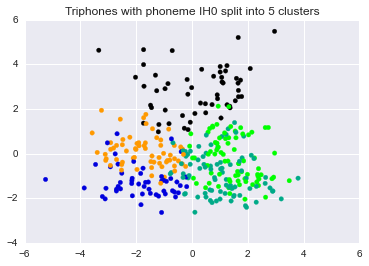

In [46]:
# visualizing results

def visualize_results(data, n, phoneme, clusters):
    pca = PCA(2)
    reduced = pca.fit_transform(data)
    colors = cm.spectral(clusters.astype(float) / n)
    plt.scatter(reduced[:,0], reduced[:,1], color=colors)
    plt.title("Triphones with phoneme %s split into %s clusters" %(phoneme, n))
    plt.show()
     
visualize_results(IH0_data, 5, 'IH0', clusters_IH0)

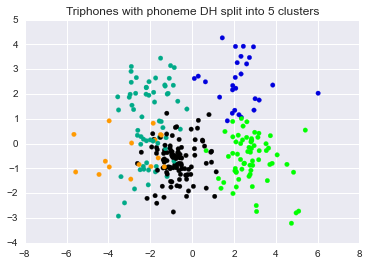

In [47]:
# the same for 'DH' phoneme

DH_data = concatenate(data, means, stds, 'DH')
clusters_DH = clstr.fit_predict(DH_data)
visualize_results(DH_data, 5, 'DH', clusters_DH)

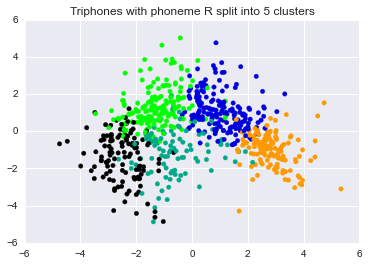

In [48]:
# the same for 'R' phoneme

R_data = concatenate(data, means, stds, 'R')
clusters_R = clstr.fit_predict(R_data)
visualize_results(R_data, 5, 'R', clusters_R)

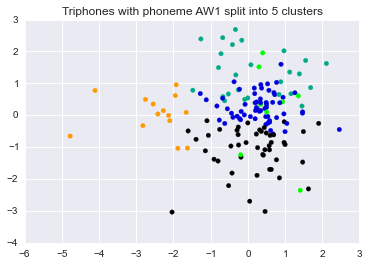

In [49]:
# the same for 'AW1' phoneme

AW1_data = concatenate(data, means, stds, 'AW1')
clusters_AW1 = clstr.fit_predict(AW1_data)
visualize_results(AW1_data, 5, 'AW1', clusters_AW1)

Кажется, что трифоны, в центре которых согласные (R, DH), неплохо кластеризуются, тогда как трифоны, в середине которых гласный (IH0, AW1), кластеризовать достаточно сложно. Вероятно, это обуловлено структурой языка: гласных фонем меньше, чем согласных, поэтому и сочетаемость у них шире. В отношении согланых, наоборот, часто действуют "запреты" на совместную встречаемость, что и позволяет их кластеризовать. 